In [1]:
#from xgboost import dask as dxgb
import xgboost as xgb
import numpy as np
import pandas as pd
import glob
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight
#import optuna
import matplotlib.pyplot as plt
import dcor
#from scipy import stats

In [2]:
data_path = "/data/rjoshi/erdos/"

In [ ]:
files = glob.glob(f"{data_path}/*.csv")
files = [f for f in files if "sample_submission" not in f]
for f in files:
    print(f)

In [4]:
df_test_transaction = pd.read_csv(files[0])
df_test_id = pd.read_csv(files[1])
df_train_id = pd.read_csv(files[2])
df_train_transaction = pd.read_csv(files[3])

In [ ]:
print(f"shape of test_transaction dataframe: {df_test_transaction.shape}")
print(f"shape of test_id dataframe: {df_test_id.shape}")
print(f"shape of train_transaction dataframe: {df_train_transaction.shape}")
print(f"shape of train_id dataframe: {df_train_id.shape}")

In [35]:
for col in df_train_transaction.columns:
    if col not in list(df_test_transaction.columns):
        print(f"column '{col}' not present in test dataset!")

column 'isFraud' not present in test dataset!


In [40]:
# It turns out the column names are different between test and train dataset :(
for col in df_train_id.columns:
    if "-".join(col.split("_")) not in list(df_test_id.columns):
        print(f"column {col} not present in test dataset")

In [59]:
len(np.unique(df_train_transaction['TransactionID']))

590540

In [60]:
len(np.unique(df_train_id['TransactionID']))

144233

In [37]:
df_train_id.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [38]:
df_test_id.head(5)

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [41]:
df_train_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_test_transaction.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
df_train_id.shape

(144233, 41)

In [171]:
df_train_transaction.shape

(590540, 394)

In [5]:
from dataclasses import dataclass,field

In [6]:
@dataclass 
class ColInstance:
    df: pd.DataFrame = field(default_factory=pd.DataFrame)
    float_cols: list[str] = field(default_factory=list)
    int_cols: list[str] = field(default_factory=list)
    str_cols: list[str] = field(default_factory=list)
    bool_cols: list[str] = field(default_factory=list)
    
    def getListsOfColTypes(self):
        for col, col_type in self.df.dtypes.to_dict().items():
            if col_type == 'float64':
                self.float_cols.append(col)
            elif col_type == 'int64':
                self.int_cols.append(col)
            elif col_type == 'object':
                self.str_cols.append(col)
            elif col_type == 'bool':
                self.bool_cols.append(col)
            else:
                print(f"type of column {col}: {col_type}")
    

In [7]:
transaction_col_instance = ColInstance(df_train_transaction)
transaction_col_instance.getListsOfColTypes()
tr_float_cols = transaction_col_instance.float_cols
tr_int_cols = transaction_col_instance.int_cols
tr_str_cols = transaction_col_instance.str_cols

In [8]:
id_col_instance = ColInstance(df_train_id)
id_col_instance.getListsOfColTypes()
id_float_cols = id_col_instance.float_cols
id_int_cols = id_col_instance.int_cols
id_str_cols = id_col_instance.str_cols

In [98]:
print("number of float columns: ", len(tr_float_cols))

number of float columns:  376


In [ ]:
dict_nan_percent = {}
for float_col in tr_float_cols:
    percentage_nan = df_train_transaction[float_col].isna().sum()/df_train_transaction[float_col].shape[0]
    if percentage_nan > 0.5:
        tr_float_cols.remove(float_col)
        continue
    dict_nan_percent[float_col] = percentage_nan
    print(f"Column name: {float_col} \n-------------------------------")
    print(df_train_transaction[float_col].describe())
    print(f"Percentage of NaNs: {percentage_nan}")
    print("-------------------------------")

dict_nan_percent = dict(sorted(dict_nan_percent.items(), key=lambda item: item[1]))

In [100]:
print("number of float columns after removing columns with many NaNs: ", len(tr_float_cols))

number of float columns after removing columns with many NaNs:  290


In [27]:
for col in tr_float_cols:
    df_train_transaction[col].plot()
    plt.savefig(f"fraud_features/{col}.png")
    plt.close()

In [ ]:
for col in tr_float_cols:
    df_train_transaction.plot.scatter(x=col, y='isFraud', c='TransactionAmt', colormap='viridis')
    plt.savefig(f"fraud_features/scatter_{col}.png")
    plt.close()

In [40]:
high_corr_features = {}
n = 0
for col in tr_float_cols:
    mask = np.logical_not(df_train_transaction[col].isna())
    nan_dropped_col = df_train_transaction[col][mask]
    disco = dcor.distance_correlation(nan_dropped_col, df_train_transaction['isFraud'][mask])
    print(col, ": ", disco)
    if disco > 0.5:
        high_corr_features[col] = disco 

/home/atlas-coffea/ML/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
/home/atlas-coffea/ML/lib/python3.10/site-packages/dcor/_dcor_internals.py:188: RuntimeWarning: overflow encountered in scalar multiply
  third_term = a_total_sum * b_total_sum / n_samples


TransactionAmt :  0.12870766182359591
card2 :  0.0705257006072572
card3 :  0.5780089840330331
card5 :  0.18964909108543082
addr1 :  0.013461082022787448
addr2 :  0.08011397084765913
dist2 :  0.03247120539991301
C1 :  0.24758904805255602
C2 :  0.300972559700221
C3 :  0.052357298103467564
C4 :  0.3183015479845553
C5 :  0.1915457795917677
C6 :  0.13773087173653434
C7 :  0.32606183585498993
C8 :  0.37291779056662827
C9 :  0.21052093599369637
C10 :  0.31607736821960514
C11 :  0.20078679266549945
C12 :  0.36942403931740075
C13 :  0.14807472188102208
C14 :  0.13130911913395707
D1 :  0.2505946019798571
D2 :  0.1344148404517765
D3 :  0.2217357666007704
D4 :  0.14483095924708755
D6 :  0.057188776741270875
D8 :  0.1655484047254655
D10 :  0.25611017037797684
D11 :  0.060145954736810836
D13 :  0.06255537444283045
D15 :  0.20796817307933596
V1 :  0.00138103143557685
V2 :  0.023450085078692527
V3 :  0.0585872349211377
V4 :  0.016966493863951982
V5 :  0.0360277128132355
V6 :  0.01262953347861987
V7 : 

In [45]:
high_corr_features.keys()

dict_keys(['card3', 'V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34', 'V44', 'V45', 'V56', 'V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V86', 'V87', 'V108', 'V111', 'V112', 'V113', 'V114', 'V123', 'V125', 'V302', 'V303', 'V304'])

In [50]:
for i in range(0, len(high_corr_features.keys()) - 1):
    list_high_corr_features = list(high_corr_features.keys())
    for j in range(1, len(high_corr_features.keys())):
        col1 = list_high_corr_features[i]
        col2 = list_high_corr_features[j]
        mask1 = np.logical_not(df_train_transaction[col1].isna())
        mask2 = np.logical_not(df_train_transaction[col2].isna())
        disco = dcor.distance_correlation(df_train_transaction[col1][mask1][mask2].dropna(), df_train_transaction[col2][mask1][mask2].dropna())
        if disco > 0.7:
            print(col1, ", ", col2, ": ", disco)

card3 ,  V15 :  0.8913625653195986
card3 ,  V16 :  0.891555348602309
card3 ,  V17 :  0.7680034156532385
card3 ,  V18 :  0.7681636128784842
card3 ,  V21 :  0.7665327935450807
card3 ,  V22 :  0.7666766129238648
card3 ,  V31 :  0.8238009635102528
card3 ,  V32 :  0.8238957599990662
card3 ,  V33 :  0.8576068351917893
card3 ,  V34 :  0.8308630441589038
card3 ,  V57 :  0.886885201207056
card3 ,  V58 :  0.8874863578323545
card3 ,  V59 :  0.784593988402575
card3 ,  V60 :  0.7846788188949143
card3 ,  V63 :  0.7826887161351567
card3 ,  V64 :  0.7822055020435061
card3 ,  V71 :  0.8384542246798592
card3 ,  V72 :  0.8391525404330419
card3 ,  V73 :  0.8484774068275509
card3 ,  V74 :  0.8234549404652851
V15 ,  V15 :  0.999999999997739
V15 ,  V16 :  0.9997572322908896
V15 ,  V17 :  0.8454729845573113
V15 ,  V18 :  0.8455765266000279
V15 ,  V21 :  0.8440699170242285
V15 ,  V22 :  0.8441642874559943
V15 ,  V31 :  0.9251460429004787
V15 ,  V32 :  0.9248203558057503
V15 ,  V33 :  0.9624810815637461
V15 ,  

<Axes: >

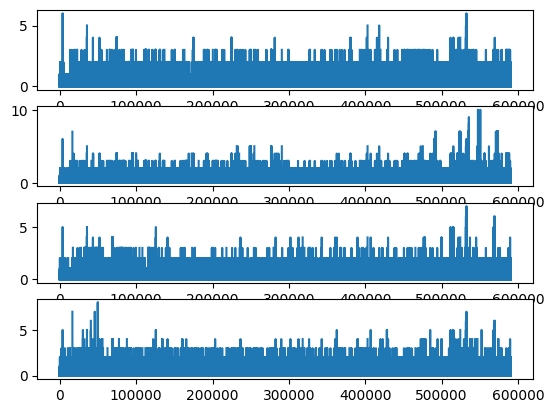

In [42]:
fig, axes = plt.subplots(4, 1)
df_train_transaction['V71'].plot(ax=axes[0])
df_train_transaction['V72'].plot(ax=axes[1])
df_train_transaction['V73'].plot(ax=axes[2])
df_train_transaction['V74'].plot(ax=axes[3])

In [17]:
V_features = [f for f in tr_float_cols if "V" in f]
corr = df_train_transaction[V_features].corr()

In [ ]:
nvars = int(np.ceil(len(V_features)/20))
for i in range(0, 20):
    lower_index1 = i * nvars
    upper_index1 = lower_index1 + nvars if i < 19 else len(V_features)
    for j in range(0, 20):
        lower_index2 = j * nvars
        upper_index2 = lower_index2 + nvars if i < 19 else len(V_features)
        subset_df = corr.iloc[lower_index1:upper_index1,lower_index2:upper_index2]
        plt.figure(figsize=(10, 8))
        sns.heatmap(subset_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})
        plt.title("Correlation heatmap")
        plt.show()

In [58]:
for col in df_train_id.columns:
    print(f"{col}\n---------------")
    print("First five values \n", df_train_id[col][0:5])
    print("unique values count: ", len(np.unique(df_train_id[col].astype(str))))
    print("-----------------")
    

TransactionID
---------------
First five values 
 0    2987004
1    2987008
2    2987010
3    2987011
4    2987016
Name: TransactionID, dtype: int64
unique values count:  144233
-----------------
id_01
---------------
First five values 
 0    0.0
1   -5.0
2   -5.0
3   -5.0
4    0.0
Name: id_01, dtype: float64
unique values count:  77
-----------------
id_02
---------------
First five values 
 0     70787.0
1     98945.0
2    191631.0
3    221832.0
4      7460.0
Name: id_02, dtype: float64
unique values count:  115656
-----------------
id_03
---------------
First five values 
 0    NaN
1    NaN
2    0.0
3    NaN
4    0.0
Name: id_03, dtype: float64
unique values count:  25
-----------------
id_04
---------------
First five values 
 0    NaN
1    NaN
2    0.0
3    NaN
4    0.0
Name: id_04, dtype: float64
unique values count:  16
-----------------
id_05
---------------
First five values 
 0    NaN
1    0.0
2    0.0
3    0.0
4    1.0
Name: id_05, dtype: float64
unique values count:  94
---